In [228]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats
import pymc3 as pm
%matplotlib inline
from IPython.core.pylabtools import figsize

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [229]:
DB = "..\\Data\\hockey_data_goalies.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

<h2>Determine the Prior Distribution</h2>

In [236]:
def season_finder(date):
    if date.month > 8:
        return date.year
    else:
        return date.year-1
 

#get player logs for the last 3 years

q = """SELECT * 
        FROM player_log 
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {0}
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {1}
        """.format(2000.66,2015.66)
games = run_query(q)
games['date_game'] = games['date_game'].astype('datetime64') #convert to datetime
games['time_on_ice'] = games['time_on_ice'].str.extract(r'(\d*)\:\d*')[0].astype(int)+games['time_on_ice'].str.extract(r'\d*\:(\d*)')[0].astype(int)/60
games['season'] = games['date_game'].map(lambda x: season_finder(x))
gamesgb = games.groupby(['player_id','season']).sum()
#remove players who've played less than 60 minutes in a season
gamesgb = gamesgb[gamesgb['time_on_ice']>120]
gamesgb['save_pct'] = gamesgb['saves']/gamesgb['shots_against']

231.13871532909513 24.219492250631745 0 1


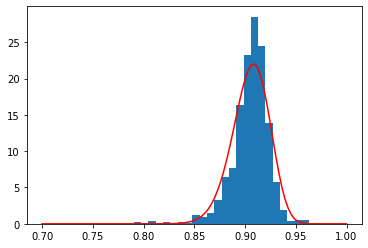

In [311]:
data = gamesgb['save_pct'].to_list()

bin_no = 25


a,b,loc,scale = stats.distributions.beta.fit(data,floc=0,fscale=1)

print(a,b,loc,scale)

x = np.linspace(0.7,1,100)

fitted_data = stats.distributions.beta.pdf(x,a,b,loc,scale)

plt.hist(gamesgb['save_pct'].to_list(), bins = bin_no,density=True)
plt.plot(x,fitted_data,'r-')
plt.show()

In [438]:
#pick a player for the season...
q = """SELECT pl.player,log.*
        FROM player_log log
        LEFT JOIN player_list pl ON pl.unique_id= log.player_id
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {0}
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {1}
        AND team_id ="TOR"
        """.format(2016.66,2017.66)
tor = run_query(q)
tor['time_on_ice'] = tor['time_on_ice'].str.extract(r'(\d*)\:\d*')[0].astype(int)+tor['time_on_ice'].str.extract(r'\d*\:(\d*)')[0].astype(int)/60

In [441]:
torgb = tor.groupby('player').sum()
torgb['save_pct'] = torgb['saves']/torgb['shots_against']
torgb.iloc[:,1:]

,goals_against,shots_against,saves,save_pct,shutouts,pen_min,time_on_ice,injured
player,,,,,,,,
Curtis McElhinney,36,418,382,0.913876,1,0,758.733333,0
Frederik Andersen,169,2052,1883,0.917641,4,16,3799.333333,2
Jhonas Enroth,18,141,123,0.872340,0,0,274.433333,0


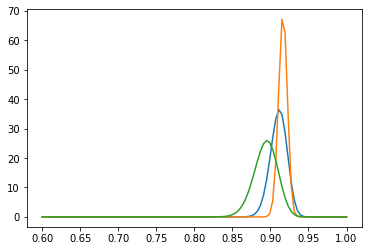

In [314]:
x = np.linspace(0.6,1,100)

for i in torgb.index:
    plt.plot(x,stats.distributions.beta.pdf(x,a+torgb.loc[i,'saves'],b+torgb.loc[i,'goals_against'],loc,scale),label=i)
    stats.distributions.beta.rvs(x,a+torgb.loc[i,'saves'],b+torgb.loc[i,'goals_against'],loc,scale)
plt.show()

In [ ]:
def goaliemc(team,year):
    """
    
    """
    a = 231.14
    b = 24.2
    
    #pick a player for the season...
    q = """SELECT pl.player,log.*
        FROM player_log log
        LEFT JOIN player_list pl ON pl.unique_id= log.player_id
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {0}
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {1}
        AND team_id ="TOR"
        """.format(2016.66,2017.66)

In [444]:
date = '2017-01-21'
team = 'TOR'
year = 2016
a = 231.14
b = 24.2
loc=0
scale=1
#pick a player for the season...
q = """SELECT *
    FROM team_log
    WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {1}
    AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {2}
    AND team_id ="{0}"
    """.format(team,year+.66,year+1.66)
games = run_query(q)
pregames = games[games['date_game']<date]
no_games = pregames.shape[0]
games_won = print((pregames['game_outcome']=='W').sum())

21


In [434]:
q = """SELECT *
    FROM team_log
    WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {1}
    AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {2}
    AND team_id ="{0}"
    """.format(team,year+.66,year+1.66)
games = run_query(q)
pregames = games[games['date_game']<date]
no_games = pregames.shape[0]
games_won = print((pregames['game_outcome']=='W').sum())
for i in torgb.index:
    result = 0
    wins = 0
    tot_mc = int(50000/no_games)
    for x in range(tot_mc):
        result += sum(pregames['shots_against']*(1-stats.distributions.beta.rvs(231.14+torgb.loc[i,'saves'],24.2+torgb.loc[i,'goals_against'],0,1,no_games))-pregames['opp_goals'])
        wins += sum(np.round(pregames['shots_against']*(1-stats.distributions.beta.rvs(231.14+torgb.loc[i,'saves'],24.2+torgb.loc[i,'goals_against'],0,1,no_games)),0)<pregames['goals'])

    print("%s allows %0.2f more goals per game resulting in %d more wins" % (i,result/(50000),wins/(tot_mc)-21))

Curtis McElhinney allows -0.04 more goals per game resulting in 0 more wins
Frederik Andersen allows -0.23 more goals per game resulting in 1 more wins
Jhonas Enroth allows 0.52 more goals per game resulting in -5 more wins


In [500]:
team_value = "TOR"
year_value = "2016"
date_game = '2017-01-21'
q = ("""WITH goalies as 
        (SELECT player_id,
                SUM(goals_against) GA,
                SUM(saves) SAVES,
                SUM(CAST(SUBSTR(time_on_ice,1,2) AS INT)) TOI,
                ROUND(1-CAST(SUM(goals_against) AS FLOAT)/CAST(SUM(saves)+ SUM(goals_against) as FLOAT),3) SPCT
        FROM player_log pl
        WHERE team_id=\"{0}\"
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {1}
        AND date_game < \"{2}\"
        GROUP BY player_id)
        
        SELECT pl.*, g.GA, g.SAVES, g.SPCT, g.TOI
        FROM goalies g
        LEFT JOIN player_list pl ON pl.unique_id=g.player_id""".format(team_value,int(year_value) + .66,date_game))
active_players = run_query(q)
active_players_T = active_players.transpose()
active_players_T.columns = active_players_T.loc['player']
active_players_T.drop(['unique_id','player'],inplace=True)
active_players_T = active_players_T.iloc[2:,:]
active_players_T.index = ['Height(cm)','Weight(kg)','Total Games','Goals Allowed','Saves','SV%','Minutes']
active_players_T.reset_index(inplace=True)
active_players_T = active_players_T.rename(columns={'index':"Stat"})

In [503]:
active_players_T

player,Stat,Frederik Andersen,Jhonas Enroth,Curtis McElhinney
0,Height(cm),193,178,188
1,Weight(kg),104,79,92
2,Total Games,369,153,237
3,Goals Allowed,97,18,2
4,Saves,1080,123,35
5,SV%,0.918,0.872,0.946
6,Minutes,2132,272,60
